# Семантическая сегментация. Семинар

На этом семинаре мы реализуем и обучим модели семантической сегментации кошек

## Датасет

Будем работать с датасетом COCO - Common Objects in Context. \
ссылка на источник: https://cocodataset.org/#home \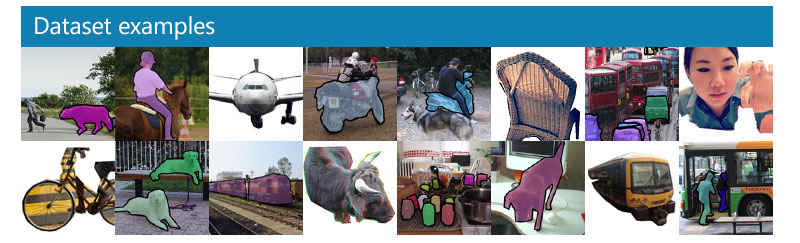

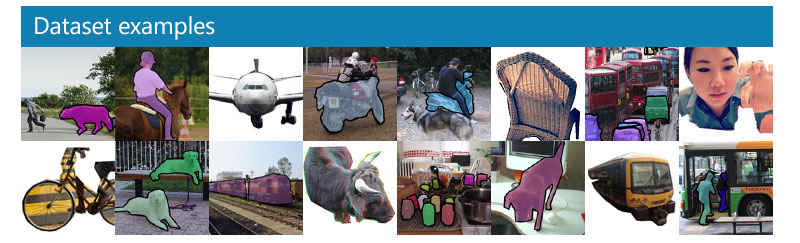

### Задание 1 - установка и импорт библиотек

In [ ]:
!pip install pycocotools
!pip install --upgrade scikit-image scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

from random import shuffle
from PIL import Image

from pycocotools.coco import COCO

### Задание 2 - скачивание датасета и парсинг с помощью COCO API
Более подробные инструкции к датасету COCO и его применению в различных задачах модно найти здесь - https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation

In [ ]:
# Скачиваем тренировочную и валидационную выборки датасета COCO с аннотациями
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2024-05-10 07:44:44--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.44.188, 16.182.32.17, 16.182.71.193, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.44.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  62.9MB/s    in 3m 28s  

2024-05-10 07:48:12 (61.9 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2024-05-10 07:48:12--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.136.249, 52.217.199.249, 3.5.28.234, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.136.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>] 

In [ ]:
# Распаковка
!unzip train2014.zip
!unzip val2014.zip
!unzip annotations_trainval2014.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: val2014/COCO_val2014_000000564166.jpg  
 extracting: val2014/COCO_val2014_000000323327.jpg  
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val20

In [ ]:
!rm *.zip

In [ ]:
# Перегруппируем в более удобную папку
!mkdir coco2014
!mkdir coco2014/images
!mv train2014 coco2014/images
!mv val2014 coco2014/images
!mv annotations/ coco2014/

Посмотрим на классы датасета COCO

In [ ]:
# Инициализируем валидационную выборку
dataDir='coco2014'
dataType='val2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
imageDir = '{}/images/{}/'.format(dataDir, dataType)

# Инициализация COCO api для аннотаций
coco=COCO(annFile)

loading annotations into memory...
Done (t=6.38s)
creating index...
index created!


In [ ]:
# Выводим все классы представленные в датасете
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)

number of categories:  80
[{'supercategory': 'person', 'id': 1, 'name': 'person'}]
[{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}]
[{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]
[{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}]
[{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]
[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}]
[{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]
[{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}]
[{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}]
[{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}]
[{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}]
[{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}]
[{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}]
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
[{'supercategory': 'animal', 'id': 16, 'name': 'bird'}]
[{'supercategory': 'animal', 'id': 17, 'name': 'cat'}]
[{'supercategory': 'animal',

#### Извлечение изображений и масок для выбранного класса

Загрузка изображений

In [ ]:
# Загрузка изображений по id
image_ids = coco.getImgIds()
image_id = image_ids[0]  # можно изменить id=0 на другой
image_info = coco.loadImgs(image_id)
print(image_info)

[{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}]


Загрузка аннотаций

In [ ]:
# Загрузка аннотаций по id
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)

Фильтрация датасета по классам - оставим только кошачий

In [ ]:
# Получаем id нужных нам классов
filterClasses = ['cat']
catIds = coco.getCatIds(catNms=filterClasses)
print(catIds)

[17]


In [ ]:
# Загрузка информации о классе по id
catID = 17
print(coco.loadCats(ids=catID))

# Получение изображения в котором есть выбранный класс
imgId = coco.getImgIds(catIds=[catID])[0]
print(imgId)

[{'supercategory': 'animal', 'id': 17, 'name': 'cat'}]
73729


Отрисовка изображения

Annotations for Image ID 73729:
COCO_val2014_000000073729.jpg


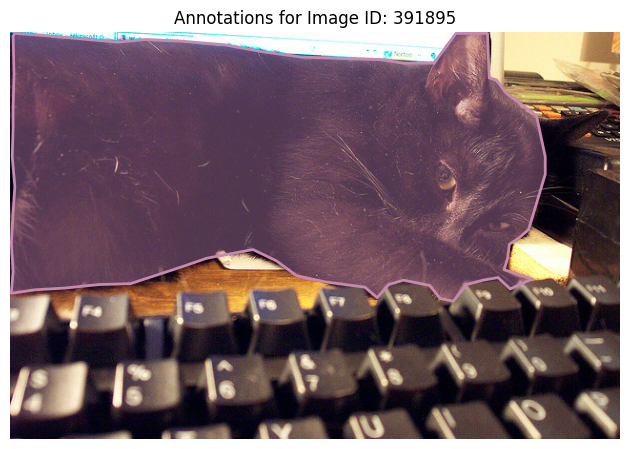

In [ ]:
print(f"Annotations for Image ID {imgId}:")
ann_ids = coco.getAnnIds(imgIds=[imgId], catIds=[catID], iscrowd=None)
anns = coco.loadAnns(ann_ids)

image_path = coco.loadImgs(imgId)[0]['file_name']
print(image_path)
image = plt.imread(imageDir + image_path)
plt.imshow(image)

# Отрисовка аннотаций
coco.showAnns(anns, draw_bbox=False)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(image_id))
plt.tight_layout()
plt.show()

Получение бинарной маски

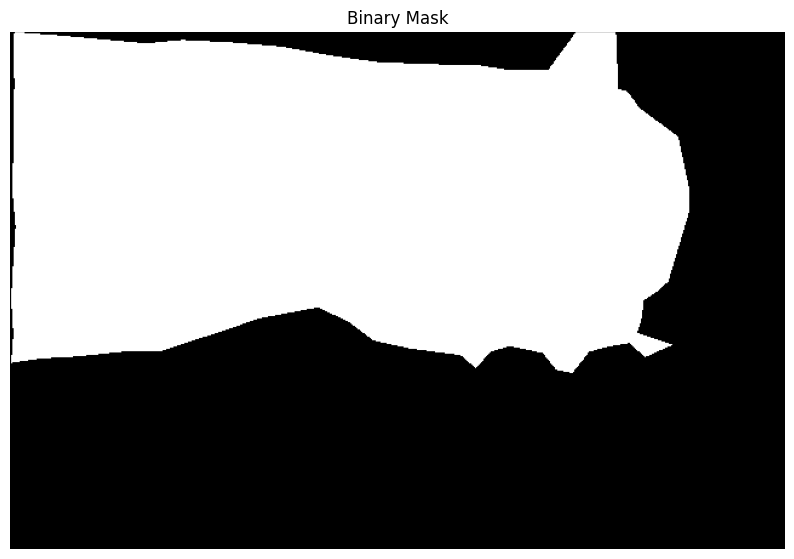

In [ ]:
# Получение размеров изображения
image_info = coco.loadImgs(imgId)[0]
height, width = image_info['height'], image_info['width']

# Создание пустой бинарной маски такого же размера как изображение
binary_mask = np.zeros((height, width), dtype=np.uint8)

# Проход по аннотациям и отрисовка бинарной маски
for annotation in anns:
    segmentation = annotation['segmentation']
    mask = coco.annToMask(annotation)

    # Добавление маски к общей
    binary_mask += mask

# Отрисовка
plt.figure(figsize=(10,10))
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.title('Binary Mask')
plt.savefig('binary_mask.png', dpi=300)
plt.show()

### Задание 3 - Фильтрация датасета по классу

In [ ]:
# Пути до файлов с аннотациями
ANNOTATION_FILE_TRAIN = 'coco2014/annotations/instances_train2014.json'
ANNOTATION_FILE_VAL = 'coco2014/annotations/instances_val2014.json'

# Нужные нам классы
classes = ['cat']

# Загрузка тренировочной выборки
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=classes)
imgIds_train = coco_train.getImgIds(catIds=catIds_train)
imgDict_train = coco_train.loadImgs(imgIds_train)

# Загрузка валидационной выборки
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
imgDict_val = coco_val.loadImgs(imgIds_val)

# Выведем размеры выборок и классов
print(len(imgIds_train), len(catIds_train))
print(len(imgIds_val), len(catIds_val))

# Перемешаем id изображений
shuffle(imgIds_train)
shuffle(imgIds_val)

# Выберем подмножество из каждой выборки (чтобы данных было не так много)
imgIds_val = imgIds_val[0:600]
imgIds_train = imgIds_train[0:6000]
# Список названий изображений для каждой выборки
train_images_cat = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images_cat = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in imgIds_val]

# Кол-во картинок в выборках
print(len(train_images_cat), len(val_images_cat))

# Кол-во файлов в соответствующих папках
len(os.listdir("coco2014/images/train2014"))
len(os.listdir("coco2014/images/val2014"))

# В этой папке будем сохранять маски для трейна
!mkdir mask_train_2014

# номер изображения
count = 0

# Извлекаем и сохраняем маски
for ID in imgIds_train:

    # путь до маски
    file_path = "mask_train_2014/COCO_train2014_{0:012d}.jpg".format(ID)

    # рандомное изображение из тренировочной выборки
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Извлечение аннотаций для этого изображения
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # Собираем бинарную маску
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])

    # Сохраняем маску как изображение
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count = count + 1

# В этой папке будем сохранять маски для валидации
!mkdir mask_val_2014

# новый счетчик для валидации
count = 0

# аналогичное сохранение масок
for ID in imgIds_val:

    file_path = "mask_val_2014/COCO_val2014_{0:012d}.jpg".format(ID)

    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count = count + 1


loading annotations into memory...
Done (t=12.87s)
creating index...
index created!
loading annotations into memory...
Done (t=7.65s)
creating index...
index created!
2818 1
1480 1
2818 600


Удалим лишние данные, чтобы не забивать память

In [ ]:
image_files = set([os.path.splitext(filename)[0] for filename in os.listdir('coco2014/images/val2014')])
mask_files = set([os.path.splitext(filename)[0] for filename in os.listdir('mask_val_2014')])
matching_files = list(image_files.intersection(mask_files))

In [ ]:
all_val_images = os.listdir('coco2014/images/val2014')
for file_name in all_val_images:
    if os.path.splitext(file_name)[0] not in matching_files:
        os.remove(os.path.join('coco2014/images/val2014/', file_name))

In [ ]:
all_val_images = os.listdir('coco2014/images/val2014')
len(all_val_images)

600

In [ ]:
image_files = set([os.path.splitext(filename)[0] for filename in os.listdir('coco2014/images/train2014')])
mask_files = set([os.path.splitext(filename)[0] for filename in os.listdir('mask_train_2014')])
matching_files = list(image_files.intersection(mask_files))

all_train_images = os.listdir('coco2014/images/train2014')
for file_name in all_train_images:
    if os.path.splitext(file_name)[0] not in matching_files:
        os.remove(os.path.join('coco2014/images/train2014/', file_name))

all_train_images = os.listdir('coco2014/images/train2014')
len(all_train_images)

2818

Также для удобства лучше сохранить полученный набор в архив и на гугл диск, чтобы в случае отключения среды не скачивать заново весь COCO

In [ ]:
# import shutil
# shutil.make_archive('coco_2014_cats', 'zip', './', './')

'/content/coco_2014_cats.zip'

### Задание 4 - Класс датасета и даталодеры

#### Загрузка с гугл диска готового датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip drive/MyDrive/coco_2014_cats.zip

Streaming output truncated to the last 5000 lines.
  inflating: coco2014/images/train2014/COCO_train2014_000000354517.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000123916.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000192575.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000060482.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000492485.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000222145.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000285699.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000295017.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000383640.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000379165.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000228029.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000018819.jpg  
  inflating: coco2014/images/train2014/COCO_train2014_000000110250.jpg  


#### Напишем свой класс датасета по канонам [Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from glob import glob
import cv2
import numpy as np

class CustomDataset(Dataset):
    # Инициализация класса, передаем папки с данными и пути для всех изображений выборки
    def __init__(self, images_dir, masks_dir, images_paths, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = images_paths

    # Метод возвращает размер датасета
    def __len__(self):
        return len(self.image_paths)

    # Метод возвращает изображение и маску для него по индексу в выборке
    def __getitem__(self, idx):
        # Путь до выбранного изображения
        img_path = self.image_paths[idx]
        # Чтение изображения
        image = cv2.imread(img_path)[..., ::-1] / 255
        image = image.astype(np.float32)
        # Путь до маски
        mask_path = img_path.replace(f'{self.images_dir}/', f'{self.masks_dir}/')
        # Чтение маски
        mask = cv2.imread(mask_path)[..., 0] / 255
        # Тут мы накладываем преобразования - например, аугментации + перевод массивов в тензоры
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, torch.unsqueeze(mask, 0)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose(
    [
        # A.PadIfNeeded(
        #     min_height=256,
        #     min_width=256,
        #     border_mode=cv2.BORDER_CONSTANT),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.4, rotate_limit=20, p=0.5),
        A.Resize(256, 256),
        # A.HorizontalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.2),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(p=1.0)
    ]
)

val_transform = A.Compose(
    [
        # A.PadIfNeeded(
        #     min_height=256,
        #     min_width=256,
        #     border_mode=cv2.BORDER_CONSTANT),
        A.Resize(256, 256),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

train_images_dir = 'coco2014/images/train2014'
train_masks_dir = 'mask_train_2014'
val_images_dir = 'coco2014/images/val2014'
val_masks_dir = 'mask_val_2014'
train_images_paths = glob(f'{train_images_dir}/*')[:1000]
val_images_paths = glob(f'{val_images_dir}/*')[:100]

train_dataset = CustomDataset(train_images_dir, train_masks_dir, train_images_paths, train_transform)
val_dataset = CustomDataset(val_images_dir, val_masks_dir, val_images_paths, val_transform)

In [ ]:
# Выведем размеры полученных датасетов
len(train_dataset), len(val_dataset)

(1000, 100)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=True)

Чтобы убедиться, что наша нейронная сеть будет получать на вход то что нужно - посмотрим на вывод полученных датасетов

In [ ]:
img, mask = val_dataset[0]

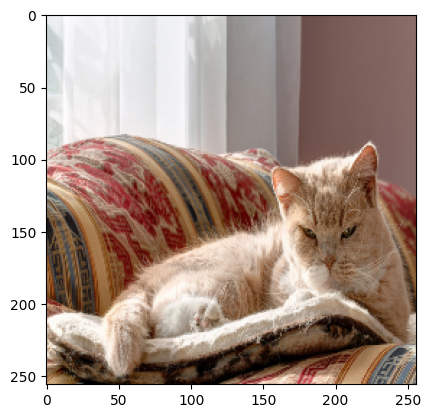

In [ ]:
plt.imshow(img.numpy().transpose(1, 2, 0))

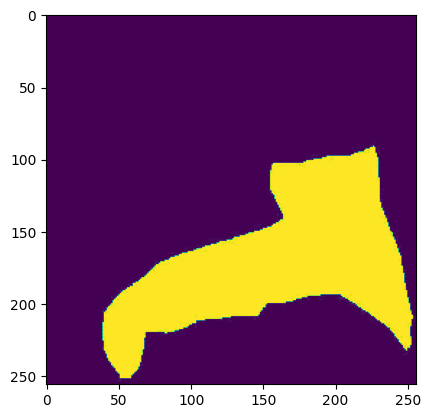

In [ ]:
plt.imshow(mask[0].numpy())

## Архитектуры нейронных сетей для сегментации

### Задание 5 - импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

# from matplotlib import rcParams
# rcParams['figure.figsize'] = (15,4)

### Задание 6 - реалиация SegNet

[**SegNet**](https://arxiv.org/pdf/1511.00561v3) - архитектура полностью сверточной нейронной сети для семантической сегментации. Декодер увеличивает карту активаци, полученную из энкодера с использованием индексов пулинга, переданных из его кодера, для создания разреженных карт объектов. Затем он выполняет свертку с обучаемым набором фильтров, чтобы уплотнить карту объектов. Выходные карты активации декодера передаются в классификатор soft-max для попиксельной классификации.


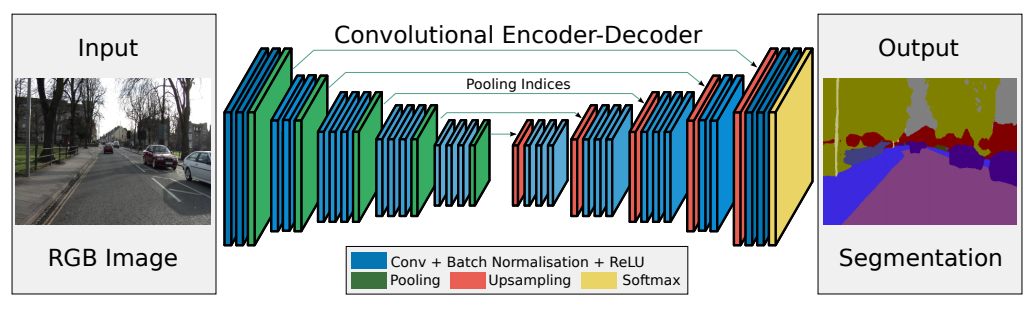

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Энкодер (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64)
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128)
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512)
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 32 -> 16

        # Декодер (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128)
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64)
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32)
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )

    def forward(self, x):
        # encoder
        e0, e0_maxpool_indices = self.pool0(F.relu(self.enc_conv0(x)))
        e1, e1_maxpool_indices  = self.pool1(F.relu(self.enc_conv1(e0)))
        e2, e2_maxpool_indices  = self.pool2(F.relu(self.enc_conv2(e1)))
        e3, e3_maxpool_indices  = self.pool3(F.relu(self.enc_conv3(e2)))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(e3, e3_maxpool_indices)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0, e2_maxpool_indices)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1, e1_maxpool_indices)))
        d3 = self.dec_conv3(self.upsample3(d2, e0_maxpool_indices)) # no activation
        return d3

### Задание 7 - реализация U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура сверточной нейронной сети, созданная для решения задачи семантической сегментации медицинских изображений. Архитектура показала себя хорошо не только в данном контексте, но и на других данных а также в других задачах. Получая на вход изображение, она вывводит изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

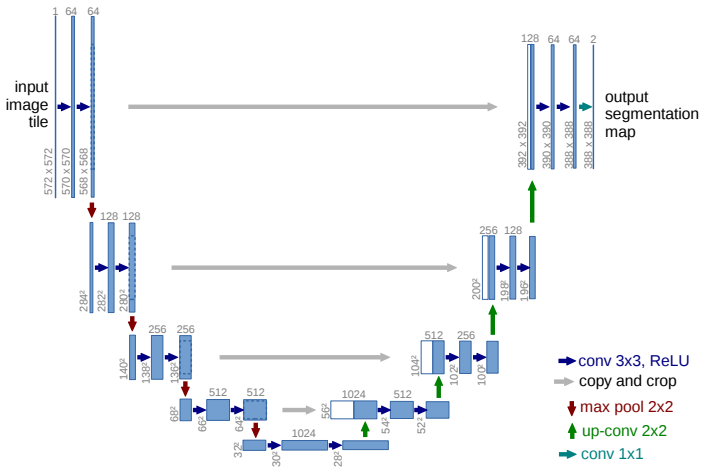

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Энкодер (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()

        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)# 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Декодер (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)    # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        # конкатенация по каналам dim=1
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3

## Метрики и функции потерь

### Задание 7 - метрика IoU

Будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Для примера посмотрим на таргет (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Источник: https://www.jeremyjordan.me/evaluating-image-segmentation-models/

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Ноль если if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Ноль если оба равны 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # Избегаем 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # Сравнение с трэшхолдом

    return thresholded  #

### Задание 8 - BCE Loss

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Обучение модели

### Задание 9 - функция для обучения

In [ ]:
# визуализация графиков обучения
def visualize(train_loss, val_loss, train_score, val_score, title):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label = 'train_loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_score, label = 'train_score')
    plt.plot(val_score, label = 'val_score')
    plt.title('Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')

    plt.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

In [ ]:
from IPython.display import clear_output

# цикл обучения
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler, path):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    train_loss = []
    val_loss = []
    train_score = []
    val_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_train_score = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # перенос на device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # обнуляем градиент в оптимизаторе
            opt.zero_grad()
            # forward
            with torch.set_grad_enabled(True):
                Y_pred = model(X_batch)

                avg_train_score += iou_pytorch(Y_pred>0, Y_batch).mean().item()

                loss =  loss_fn(Y_batch, Y_pred)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # обновление весов

                scheduler.step() # лучше выключить при обучении своей сети без претрейна
            # суммируем лосс чтобы вывести график
            avg_loss += loss / len(data_tr)

        avg_train_score = avg_train_score / len(data_tr)

        train_score.append(avg_train_score)
        train_loss.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        avg_val_loss = 0
        avg_val_score = 0
        # промежуточные результаты
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                # перенос на device
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                # forward
                Y_val_pred = model(X_val_batch)
                vall_loss =  loss_fn(Y_val_batch, Y_val_pred)# forward-pass
                avg_val_score += iou_pytorch(Y_val_pred >0, Y_val_batch).mean().item()
                # суммируем лосс
                avg_val_loss += vall_loss / len(data_val)

        val_loss.append(avg_val_loss)
        avg_val_score = avg_val_score / len(data_val)
        val_score.append(avg_val_score)

        Y_hat = model(X_val).detach().cpu() # перенос на cpu

        # Визуализация
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    torch.save(model, path)
    return train_loss, val_loss, train_score, val_score

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    #model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            scores += metric(Y_pred>0, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
def model_scorerer(model_class, path, max_epochs, loss, data_tr, data_val):
    model_name = str(model_class).split()[0][:-1]
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model_class.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

### Задание 10 - обучение и оценка качества нейронной сети

In [ ]:
#!export LRU_CACHE_CAPACITY=1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Обучение UNet

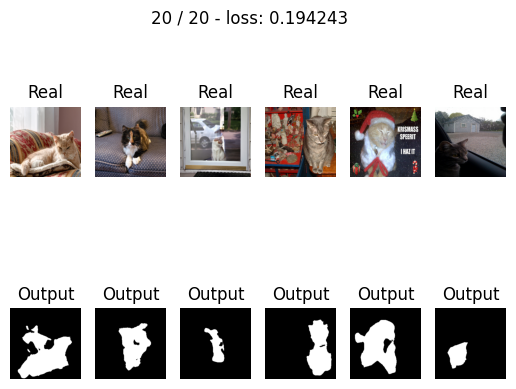

Working with UNet and bce_loss
validation score: 0.16979166865348816


In [ ]:
train_loss_unet_bce, val_loss_unet_bce, train_score_unet_bce, val_score_unet_bce, model_unet_bce = \
model_scorerer(UNet(), "unet_bce.pt", 20, bce_loss, train_dataloader, val_dataloader)

In [ ]:
!cp unet_bce.pt drive/MyDrive/

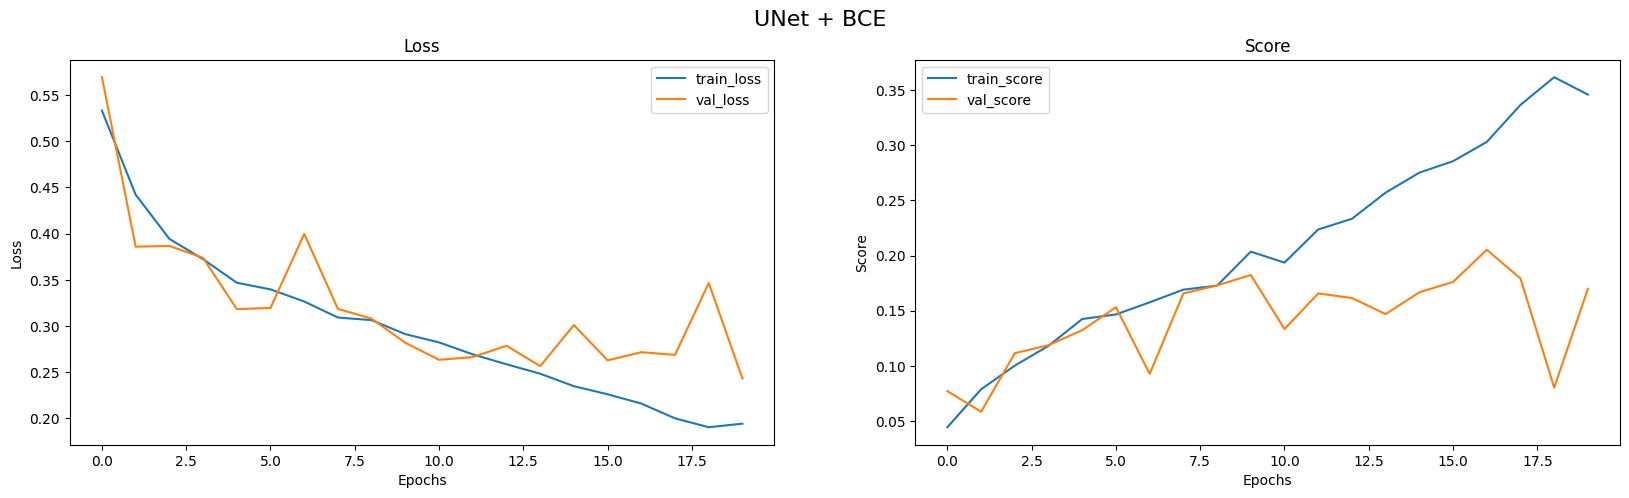

In [ ]:
train_loss_unet_bce = [x.cpu().detach().numpy() for x in train_loss_unet_bce]
val_loss_unet_bce = [x.cpu().detach().numpy() for x in val_loss_unet_bce]

visualize(train_loss_unet_bce, val_loss_unet_bce,
          train_score_unet_bce, val_score_unet_bce, "UNet + BCE")

## Фреймворки для семантической сегментации

На практике как правило не пишут вручную реализацию нейронных сетей. Чаще берут готовую реализацию и предобученные веса из torchvision или таких фреймворков как mmsegmentation, huggingface, qubvel и тд. Рассмотрим пару примеров загрузки и использования моделей из фреймворков.

### Задание 11 - Qubvel
Это фреймворк, в котором реализованые популярные архитектуры для семантической сегментации. Из него можно взять модель с предобученными весами \
https://github.com/qubvel/segmentation_models.pytorch?tab=readme-ov-file#installation

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # энкодер
    encoder_weights=None,           # предобученные веса
    in_channels=3,                  # кол-во каналов входного изображения (1 для ч/б, 3 для RGB, и т.д.)
    classes=1,                      # кол-во выходных каналов, т.е. классов
).to(device)

In [ ]:
def model_scorerer(model, model_name, path, max_epochs, loss, data_tr, data_val):
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

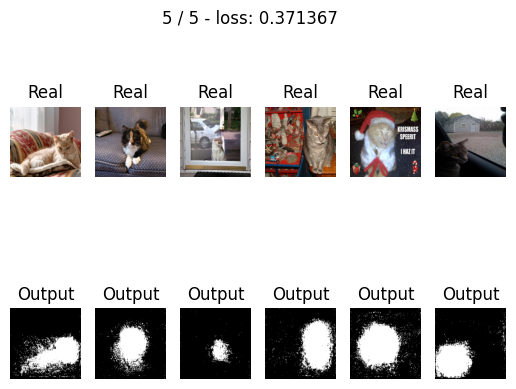

Working with Unet34 and bce_loss
validation score: 0.18958333879709244


In [ ]:
train_loss_unet34_bce, val_loss_unet34_bce, train_score_unet34_bce, val_score_unet34_bce, model_unet34_bce = \
model_scorerer(model, "Unet34", "unet34_bce.pt", 5, bce_loss, train_dataloader, val_dataloader)

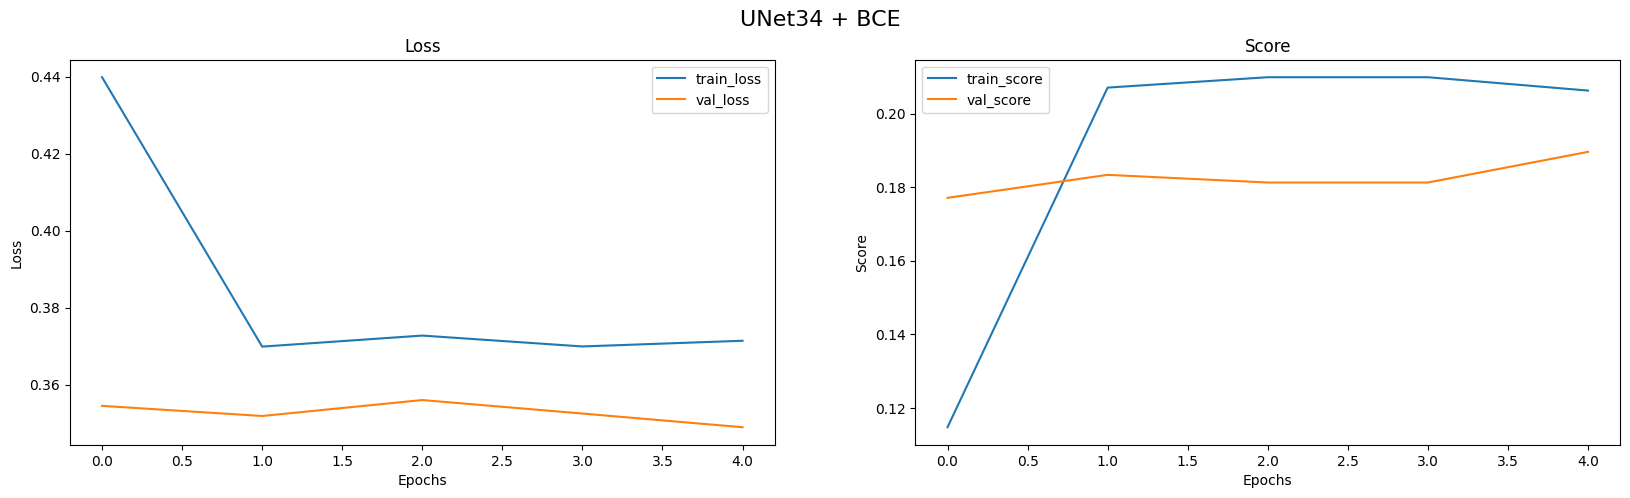

In [ ]:
train_loss_unet34_bce = [x.cpu().detach().numpy() for x in train_loss_unet34_bce]
val_loss_unet34_bce = [x.cpu().detach().numpy() for x in val_loss_unet34_bce]

visualize(train_loss_unet34_bce, val_loss_unet34_bce,
          train_score_unet34_bce, val_score_unet34_bce, "UNet34 + BCE")

In [ ]:
model

### Задание 12 - mmsegmentation

#### Установка и импорт библиотек

In [ ]:
!pip install torch==2.0.0 torchvision==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# !pip install -U openmim
# !mim install mmengine
!mim install mmcv==2.0.0

Looking in links: https://download.openmmlab.com/mmcv/dist/cu117/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: mmcv
    Found existing installation: mmcv 2.2.0
    Uninstalling mmcv-2.2.0:
      Successfully uninstalled mmcv-2.2.0


In [ ]:
!pip install --no-cache-dir mmsegmentation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.6 MB/s eta 0:00:00


In [ ]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 949.8 kB/s eta 0:00:00


In [ ]:
from mmseg.apis import inference_model, init_model, show_result_pyplot

#### Скачивание конфига и чекпоинта для PSPNet

In [ ]:
!mim download mmsegmentation --config pspnet_r50-d8_4xb4-20k_coco-stuff10k-512x512 --dest .

processing pspnet_r50-d8_4xb4-20k_coco-stuff10k-512x512...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 MiB 17.4 MB/s eta 0:00:00
Successfully downloaded pspnet_r50-d8_512x512_4x4_20k_coco-stuff10k_20210820_203258-b88df27f.pth to /content
Successfully dumped pspnet_r50-d8_4xb4-20k_coco-stuff10k-512x512.py to /content


In [ ]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcM3rWdZmwJdo8xdIq5WFe5r1z32YixtMEYYi7GXuqVg&s

/bin/bash: line 1: s: command not found
--2024-05-09 19:52:53--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcM3rWdZmwJdo8xdIq5WFe5r1z32YixtMEYYi7GXuqVg
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.196.113, 173.194.196.138, 173.194.196.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.196.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6391 (6.2K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcRcM3rWdZmwJdo8xdIq5WFe5r1z32YixtMEYYi7GXuqVg’

images?q=tbn:ANd9Gc 100%[===================>]   6.24K  --.-KB/s    in 0s      

2024-05-09 19:52:53 (52.0 MB/s) - ‘images?q=tbn:ANd9GcRcM3rWdZmwJdo8xdIq5WFe5r1z32YixtMEYYi7GXuqVg’ saved [6391/6391]



#### Инфер предобученной сети

Loads checkpoint by local backend from path: pspnet_r50-d8_512x512_4x4_20k_coco-stuff10k_20210820_203258-b88df27f.pth


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


array([[[181, 180, 187],
        [181, 180, 187],
        [182, 181, 188],
        ...,
        [198, 192, 184],
        [194, 188, 180],
        [188, 182, 172]],

       [[182, 181, 188],
        [182, 181, 188],
        [183, 182, 189],
        ...,
        [198, 192, 184],
        [194, 188, 180],
        [188, 182, 172]],

       [[183, 182, 189],
        [184, 183, 190],
        [184, 183, 190],
        ...,
        [198, 192, 184],
        [195, 188, 180],
        [188, 182, 172]],

       ...,

       [[ 13,  73,  40],
        [ 12,  74,  40],
        [ 13,  73,  40],
        ...,
        [205, 200, 195],
        [203, 197, 191],
        [198, 192, 186]],

       [[ 12,  74,  40],
        [ 12,  74,  40],
        [ 12,  74,  40],
        ...,
        [205, 200, 195],
        [203, 197, 191],
        [198, 192, 186]],

       [[ 12,  74,  40],
        [ 12,  74,  40],
        [ 12,  74,  40],
        ...,
        [205, 200, 195],
        [203, 197, 191],
        [198, 192, 186]]], dtype=uint8)
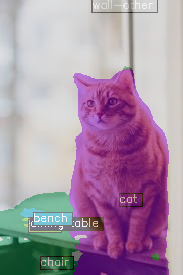

In [ ]:
from mmseg.apis import inference_model, init_model, show_result_pyplot
import mmcv

config_file = 'pspnet_r50-d8_4xb4-20k_coco-stuff10k-512x512.py'
checkpoint_file = 'pspnet_r50-d8_512x512_4x4_20k_coco-stuff10k_20210820_203258-b88df27f.pth'

# загрузка модели по конфигу и чекпоинту
model = init_model(config_file, checkpoint_file, device='cuda:0')

# инфер на одном изображении
img = 'cat.png'
result = inference_model(model, img)
# отрисовка
show_result_pyplot(model, img, result, show=True)
# сохранение
show_result_pyplot(model, img, result, show=True, out_file='result.jpg', opacity=0.5)